<a href="https://colab.research.google.com/github/rumeysaegilmez/DeepLearning/blob/main/Satellite_Images_MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

import warnings
warnings.filterwarnings('ignore')

import splitfolders
from glob import glob
import os

In [5]:
dataset = "data"
splitfolders.ratio(dataset, output="Satellite_Images", seed=101, ratio=(.7, .2, .1))

Copying files: 5631 files [00:02, 2134.87 files/s]


In [6]:
training_dir = 'Satellite_Images/train'
validation_dir = 'Satellite_Images/val'
test_dir = 'Satellite_Images/test'

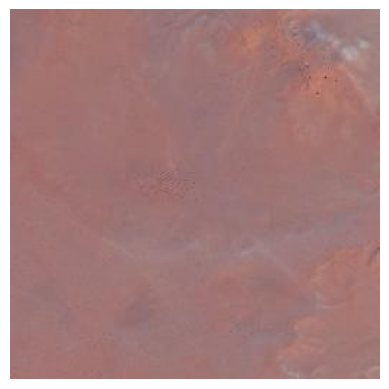

In [7]:
img = load_img(training_dir + "/desert/desert(1).jpg")
plt.imshow(img)
plt.axis("off")
plt.show()

In [8]:
x = img_to_array(img)
print(x.shape)

(256, 256, 3)


In [9]:
className = glob(training_dir + '/*')
numberOfClass = len(className)
print("NumberOfClass: ",numberOfClass)

labels = os.listdir(training_dir)
print("LabelsOfClass: ",labels)

NumberOfClass:  4
LabelsOfClass:  ['green_area', 'desert', 'water', 'cloudy']


In [10]:
Total_TrainImages = glob('Satellite_Images/train/*/*.jpg')
print("Total number of training images: ", len(Total_TrainImages))

train_image_names = pd.Series(Total_TrainImages)
train_df = pd.DataFrame()
train_df['Filename'] = train_image_names.map( lambda img_name: img_name.split("/")[-1])
train_df['ClassId'] = train_image_names.map(lambda img_name: img_name.split("/")[-2])

train_df.head(10)

Total number of training images:  3941


,Filename,ClassId
0,Forest_928.jpg,green_area
1,Forest_2867.jpg,green_area
2,Forest_392.jpg,green_area
3,Forest_575.jpg,green_area
4,Forest_1944.jpg,green_area
5,Forest_672.jpg,green_area
6,Forest_2151.jpg,green_area
7,Forest_404.jpg,green_area
8,Forest_906.jpg,green_area
9,Forest_386.jpg,green_area


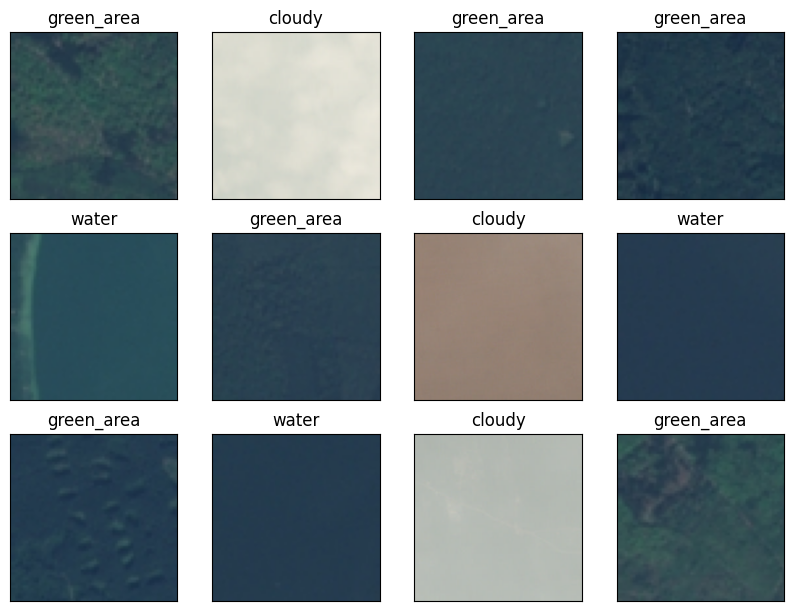

In [11]:
plot_df = train_df.sample(12).reset_index()
plt.figure(figsize=(10, 10))

for i in range(12):
    img_name = plot_df.loc[i, 'Filename']
    label = (plot_df.loc[i, 'ClassId'])
    plt.subplot(4,4,i+1)
    plt.imshow(plt.imread(os.path.join(training_dir,label, img_name)))
    plt.title(label)
    plt.xticks([])
    plt.yticks([])

In [12]:
# Define data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.8, 1.2],
    width_shift_range=0.2,
    rotation_range=20,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


# Load your dataset
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=(224, 224),
    batch_size=32,
    shuffle = True,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(
    rescale=1./255
    )
val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(224,224),
    batch_size=32,
    shuffle = True,
    class_mode='categorical'
)
test_datagen = ImageDataGenerator(
    rescale=1./255
    )
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=32,
    shuffle = False,
    class_mode='categorical'
)

Found 3941 images belonging to 4 classes.
Found 1126 images belonging to 4 classes.
Found 564 images belonging to 4 classes.


In [13]:
# Create a Sequential model
mnv2_model = Sequential()

# Add the MobileNetV2 base model without the top layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
mnv2_model.add(base_model)

# Add a GlobalAveragePooling2D layer and a dense layer for classification
mnv2_model.add(GlobalAveragePooling2D())
mnv2_model.add(Dense(512, activation='relu'))
mnv2_model.add(Dropout(0.2))
mnv2_model.add(Dense(4, activation='softmax'))

# Freeze the weights of the base model
for layer in base_model.layers:
    layer.trainable = False

# Print the model summary
mnv2_model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                           

In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
mnv2_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
history_mnv2 = mnv2_model.fit(train_generator, epochs=40, validation_data=val_generator)

Epoch 1/40
124/124 [==============================] - 291s 2s/step - loss: 0.3417 - accuracy: 0.8734 - val_loss: 0.1135 - val_accuracy: 0.9583
Epoch 2/40
124/124 [==============================] - 274s 2s/step - loss: 0.1704 - accuracy: 0.9414 - val_loss: 0.0814 - val_accuracy: 0.9760
Epoch 3/40
124/124 [==============================] - 319s 3s/step - loss: 0.1214 - accuracy: 0.9558 - val_loss: 0.0634 - val_accuracy: 0.9813
Epoch 4/40
124/124 [==============================] - 311s 3s/step - loss: 0.1216 - accuracy: 0.9571 - val_loss: 0.0576 - val_accuracy: 0.9813
Epoch 5/40
124/124 [==============================] - 291s 2s/step - loss: 0.1197 - accuracy: 0.9579 - val_loss: 0.0974 - val_accuracy: 0.9583
Epoch 6/40
124/124 [==============================] - 276s 2s/step - loss: 0.0774 - accuracy: 0.9718 - val_loss: 0.0370 - val_accuracy: 0.9876
Epoch 7/40
124/124 [==============================] - 289s 2s/step - loss: 0.0782 - accuracy: 0.9706 - val_loss: 0.1022 - val_accuracy: 0.9680

In [16]:
print(history_mnv2.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


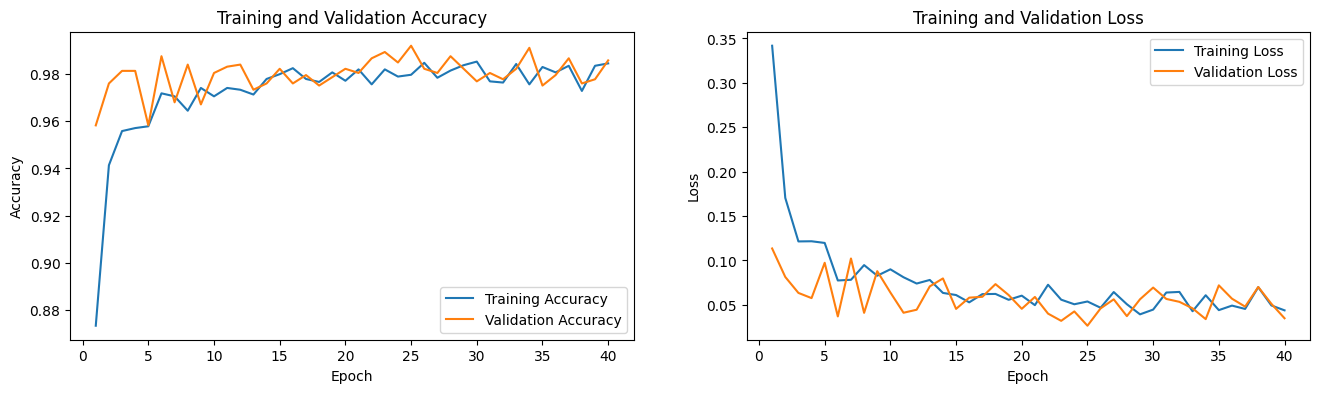

In [17]:
acc = history_mnv2.history['accuracy']
val_acc = history_mnv2.history['val_accuracy']
loss = history_mnv2.history['loss']
val_loss = history_mnv2.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
score = mnv2_model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

18/18 [==============================] - 28s 2s/step - loss: 0.0348 - accuracy: 0.9823
Test loss: 0.034768372774124146
Test accuracy: 0.9822695255279541


In [23]:
predict=mnv2_model.predict(test_generator)
# predict the class label
y_classes = np.argmax(predict, axis=1)
y_classes

18/18 [==============================] - 25s 1s/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [24]:
from sklearn.metrics import classification_report

print(classification_report(test_generator.classes, y_classes))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       150
           1       1.00      1.00      1.00       114
           2       0.96      0.99      0.97       150
           3       0.99      0.94      0.97       150

    accuracy                           0.98       564
   macro avg       0.98      0.98      0.98       564
weighted avg       0.98      0.98      0.98       564

